In [1]:
import sys
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append("C:/Users/r02as18/git/gempy/")
import gempy as gp

Devito is not working


Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'C:\\Users\\r02as18\\AppData\\Local\\Temp\\try_flags_a52xgtod.c:4:19: fatal error: cudnn.h: No such file or directory\r\ncompilation terminated.\r\n'
Mapped name None to device cuda: Quadro M1200 (0000:01:00.0)


Freenect is not installed. Sandbox wont work. Good luck


In [2]:
geo_data = gp.create_data([0,2000,0,2000,0,2000],
                          [100,100,100],
                          path_o = "C:/Users/r02as18/git/gempy/notebooks/input_data/tut_chapter1/simple_fault_model_orientations.csv", # importing orientation (foliation) data
                          path_i = "C:/Users/r02as18/git/gempy/notebooks/input_data/tut_chapter1/simple_fault_model_points.csv") # importing point-positional interface data

gp.set_series(geo_data, {"Fault_Series":'Main_Fault',
                         "Strat_Series": ('Sandstone_2','Siltstone', 'Shale', 'Sandstone_1')},
                          order_series = ["Fault_Series", 'Strat_Series'],
                          order_formations=['Main_Fault',
                                            'Sandstone_2','Siltstone', 'Shale', 'Sandstone_1'], verbose=0)

In [3]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1,1], output='geology', compile_theano=True, theano_optimizer='fast_compile')

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cuda
Precision:  float32
Number of faults:  1


In [4]:
grid = []
for x in np.arange(0,2000,20):
    for y in [1000]:
        for z in np.arange(0,2000,20):
            grid.append([x,y,z])
grid = np.array(grid)

In [162]:
interp_data.geo_data_res = geo_data_res_stoch
interp_data.update_interpolator()

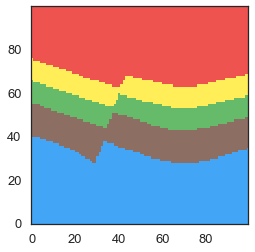

In [167]:
lb, fb = gp.compute_model_at(grid, interp_data)
plt.imshow(lb[0].reshape(100,100).T, origin="lower", cmap=gp.plotting.colors.cmap, norm=gp.plotting.colors.norm);

In [37]:
geo_data.resolution = [100, 1, 100]
G, C, *topo = gp.topology_compute(geo_data, lb[0], fb[::2])

In [8]:
from copy import deepcopy
geo_data_res_stoch = deepcopy(interp_data.geo_data_res)

In [104]:
priors = []
priors_names = []

for fmt in geo_data.formations.index:
    if "fault" in fmt or "Fault" in fmt or "basement" in fmt:
        continue
    priors.append(ss.norm(0,100))
    priors_names.append(fmt)

In [153]:
# sample
n_iter = 1000
prior_samples = []
for prior in priors:
    prior_samples.append(prior.rvs(n_iter))
    
prior_samples = np.array(prior_samples)

In [106]:
prior_samples.shape

(4, 100)

## Forward simulate models

In [154]:
import tqdm

lbs = []
fbs = []
for n in tqdm.tqdm(range(n_iter)):
    for i, fmt in enumerate(priors_names):
        f = interp_data.geo_data_res.interfaces["formation"] == fmt
        interp_data.geo_data_res.interfaces.set_value(f, "Z", geo_data_res_stoch.interfaces[f]["Z"] + (prior_samples[i, n] / interp_data.rescaling_factor))

    interp_data.update_interpolator()
    
    # print(np.sum(interp_data.geo_data_res.interfaces["Z"]))
    
    lb, fb = gp.compute_model_at(grid, interp_data)
    lbs.append(lb)
    fbs.append(fb)
    
lbs = np.array(lbs)

  2%|█▋                                                                                     | 19/1000 [00:05<04:19,  3.78it/s]C:\Users\r02as18\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.5693840771955365e-08 / 5.960464477539063e-08
  RuntimeWarning)
  6%|█████▋                                                                                 | 65/1000 [00:17<04:13,  3.69it/s]C:\Users\r02as18\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.428866873240622e-08 / 5.960464477539063e-08
  RuntimeWarning)
 12%|█████████▉                                                                            | 115/1000 [00:31<04:03,  3.63it/s]C:\User

In [155]:
ie, iet = gp.posterior_analysis.calculate_ie(lbs[:,0,:].astype("int"))

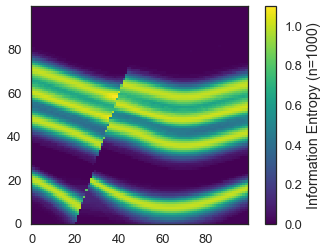

In [161]:
plt.imshow(ie.reshape(100,100).T, origin="lower", cmap="viridis")
plt.colorbar(label="Information Entropy (n="+str(lbs.shape[0])+")")

In [225]:
from scipy import fftpack


def get_2D_dct(img):
    """ Get 2D Cosine Transform of Image"""
    return fftpack.dct(fftpack.dct(img.T, norm='ortho', type=2).T, norm='ortho', type=2)


def get_2d_idct(coefficients):
    """ Get 2D Inverse Cosine Transform of Image
    """
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho', type=2).T, norm='ortho', type=2)


def get_reconstructed_image(raw):
    img = raw.clip(0, 255)
    img = img.astype('uint8')
    return img

### Compute one DCT of model image as "likelihood" for ABC

In [226]:
dct = get_2D_dct(lb[0].reshape(100,100))
model_reconstructed = get_reconstructed_image(get_2d_idct(dct))

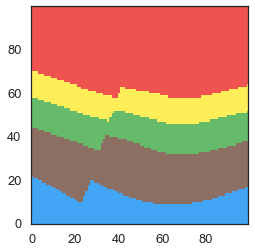

In [227]:
plt.imshow(model_reconstructed.T, origin="lower", cmap=gp.plotting.colors.cmap, norm=gp.plotting.colors.norm)

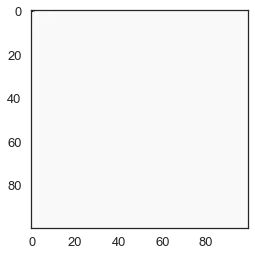

In [253]:
plt.imshow(dct)

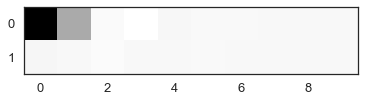

In [172]:
plt.imshow(dct[0:2,0:10])

## Just take the relevant part of the DCT:

In [179]:
dct_data = dct[0:1,0:4].astype(int)

## Rejection sampling of the simulated data:

In [249]:
epsilon = 5.
posterior_lbs = []
posterior_fbs = []

for i, lb in enumerate(lbs):
    # calculate dct of model realisation
    dct = get_2D_dct(lb[0].reshape(100,100))
    
    distance = np.average(np.sqrt(np.square(dct_data - dct[0:1,0:4])))
    if distance < epsilon:
        posterior_lbs.append(lb)
        
posterior_lbs = np.array(posterior_lbs)

In [250]:
posterior_lbs.shape

(278, 2, 10000)

In [251]:
ie_post, iet_post = gp.posterior_analysis.calculate_ie(posterior_lbs[:,0,:].astype("int"))

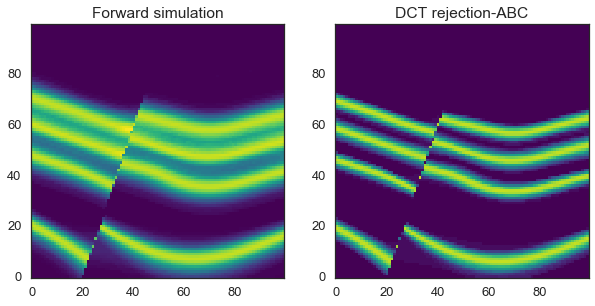

In [255]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

max_ = np.max([ie, ie_post])
min_ = np.min([ie, ie_post])

ax[0].imshow(ie.reshape(100,100).T, vmin=min_, vmax=max_, origin="lower", cmap="viridis")
im = ax[1].imshow(ie_post.reshape(100,100).T, vmin=min_, vmax=max_, origin="lower", cmap="viridis")

ax[0].set_title("Forward simulation")
ax[1].set_title("DCT rejection-ABC");